## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflo

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

from keras.layers import BatchNormalization
from keras.regularizers import l1, l2
from keras.layers import Dropout


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2,batchNorm=False,l2_=False):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if l2_==False:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(input_layer)
            elif l2_==True:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),kernel_regularizer=l2(0.001))(input_layer)
        else:
            if l2_==False:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
            elif l2_==True:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),kernel_regularizer=l2(0.001))(x)
        x = Dropout(drp_ratio)(x)
        if batchNorm:
            x = BatchNormalization()(x)

    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 40
BATCH_SIZE = 512
MOMENTUM = 0.95
Dropout_EXP = 0.25
NUM_NEURONS=[512, 256, 128]
# OPTIMIZER=['sgd','Adam']


In [7]:

results = {}

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

#THIS IS WITHOUT BATCH NORMALIZATION
for i in range(5):
    keras.backend.clear_session() # 把舊的 Graph 清掉

    #i==0: ori no dropout, no batchNorm
    #i==1: dropout, no batchNorm
    #i=2:  no dropout, batchNorm
    #i=3:  dropout, batchNorm
    #i=4:no dropout, no batchNorm,l2 regularize
    do_l2=False
    batchNorm_=False
    drp_ratio=0
    if i==0:
        model = build_mlp(input_shape=x_train.shape[1:],num_neurons=NUM_NEURONS,drp_ratio=0)
    elif i==1:
        drp_ratio=Dropout_EXP
        model = build_mlp(input_shape=x_train.shape[1:],num_neurons=NUM_NEURONS, drp_ratio=Dropout_EXP,batchNorm=False)
    elif i==2:
        batchNorm_=True
        model = build_mlp(input_shape=x_train.shape[1:],num_neurons=NUM_NEURONS, drp_ratio=0,batchNorm=True)
    elif i==3:
        batchNorm_=True
        drp_ratio=Dropout_EXP
        model = build_mlp(input_shape=x_train.shape[1:],num_neurons=NUM_NEURONS, drp_ratio=Dropout_EXP,batchNorm=True)
    else:
        do_l2=True
        model = build_mlp(input_shape=x_train.shape[1:],num_neurons=NUM_NEURONS, drp_ratio=0,batchNorm=False,l2_=True)
    model.summary()

    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

#         exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    exp_name_tag ="BNorm"+str(batchNorm_)+ "dp=%s" % str(drp_ratio)+'l2_'+str(do_l2)


    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    del model



Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 2s 46us/step - loss: 2.2660 - accuracy: 0.1503 - val_loss: 2.1250 - val_accuracy: 0.2479
Epoch 2/40
50000/50000 [==============================] - 2s 39us/step - loss: 2.1243 - accuracy: 0.2144 - val_loss: 2.0061 - val_accuracy: 0.2978
Epoch 3/40
50000/50000 [==============================] - 2s 39us/step - loss: 2.0368 - accuracy: 0.2533 - val_loss: 1.9258 - val_accuracy: 0.3236
Epoch 4/40
50000/50000 [==============================] - 2s 39us/step - loss: 1.9743 - accuracy: 0.2795 - val_loss: 1.8753 - val_accuracy: 0.3445
Epoch 5/40
50000/50000 [==============================] - 2s 40us/step - loss: 1.9316 - accuracy: 0.3027 - val_loss: 1.8361 - val_accuracy: 0.3556
Epoch 6/40
50000/50000 [==============================] - 2s 40us/step - loss: 1.8962 - accuracy: 0.3159 - val_loss: 1.8042 - val_accuracy: 0.3648
Epoch 7/40
50000/50000 [==============================] - 2s 39us/st

50000/50000 [==============================] - 2s 44us/step - loss: 1.5192 - accuracy: 0.4681 - val_loss: 1.5958 - val_accuracy: 0.4368
Epoch 4/40
50000/50000 [==============================] - 2s 43us/step - loss: 1.4485 - accuracy: 0.4920 - val_loss: 1.5514 - val_accuracy: 0.4463
Epoch 5/40
50000/50000 [==============================] - 2s 44us/step - loss: 1.3891 - accuracy: 0.5152 - val_loss: 1.5799 - val_accuracy: 0.4428
Epoch 6/40
50000/50000 [==============================] - 2s 43us/step - loss: 1.3404 - accuracy: 0.5326 - val_loss: 1.4846 - val_accuracy: 0.4746
Epoch 7/40
50000/50000 [==============================] - 2s 44us/step - loss: 1.3003 - accuracy: 0.5470 - val_loss: 1.4982 - val_accuracy: 0.4665
Epoch 8/40
50000/50000 [==============================] - 2s 43us/step - loss: 1.2610 - accuracy: 0.5611 - val_loss: 1.4736 - val_accuracy: 0.4808
Epoch 9/40
50000/50000 [==============================] - 2s 44us/step - loss: 1.2187 - accuracy: 0.5752 - val_loss: 1.4723 - val

Epoch 6/40
50000/50000 [==============================] - 2s 44us/step - loss: 1.7689 - accuracy: 0.3665 - val_loss: 1.6052 - val_accuracy: 0.4295
Epoch 7/40
50000/50000 [==============================] - 2s 45us/step - loss: 1.7238 - accuracy: 0.3852 - val_loss: 1.5819 - val_accuracy: 0.4420
Epoch 8/40
50000/50000 [==============================] - 2s 44us/step - loss: 1.6945 - accuracy: 0.3913 - val_loss: 1.5655 - val_accuracy: 0.4505
Epoch 9/40
50000/50000 [==============================] - 2s 44us/step - loss: 1.6695 - accuracy: 0.4028 - val_loss: 1.5508 - val_accuracy: 0.4508
Epoch 10/40
50000/50000 [==============================] - 2s 44us/step - loss: 1.6513 - accuracy: 0.4080 - val_loss: 1.5309 - val_accuracy: 0.4593
Epoch 11/40
50000/50000 [==============================] - 2s 45us/step - loss: 1.6287 - accuracy: 0.4145 - val_loss: 1.5228 - val_accuracy: 0.4586
Epoch 12/40
50000/50000 [==============================] - 2s 44us/step - loss: 1.6132 - accuracy: 0.4275 - val_loss

50000/50000 [==============================] - 2s 39us/step - loss: 2.8937 - accuracy: 0.4397 - val_loss: 2.8892 - val_accuracy: 0.4406
Epoch 12/40
50000/50000 [==============================] - 2s 39us/step - loss: 2.8651 - accuracy: 0.4465 - val_loss: 2.8636 - val_accuracy: 0.4465
Epoch 13/40
50000/50000 [==============================] - 2s 39us/step - loss: 2.8386 - accuracy: 0.4535 - val_loss: 2.8409 - val_accuracy: 0.4448
Epoch 14/40
50000/50000 [==============================] - 2s 39us/step - loss: 2.8132 - accuracy: 0.4591 - val_loss: 2.8190 - val_accuracy: 0.4492
Epoch 15/40
50000/50000 [==============================] - 2s 39us/step - loss: 2.7885 - accuracy: 0.4639 - val_loss: 2.7950 - val_accuracy: 0.4539
Epoch 16/40
50000/50000 [==============================] - 2s 40us/step - loss: 2.7644 - accuracy: 0.4693 - val_loss: 2.7793 - val_accuracy: 0.4582
Epoch 17/40
50000/50000 [==============================] - 2s 40us/step - loss: 2.7411 - accuracy: 0.4756 - val_loss: 2.7631

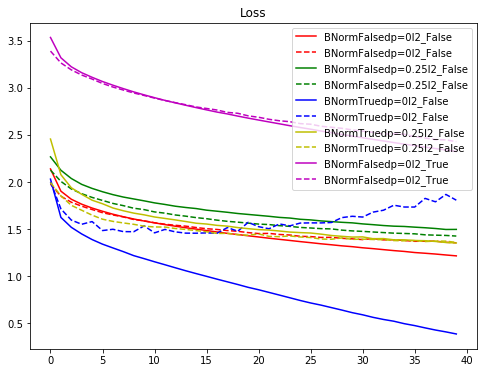

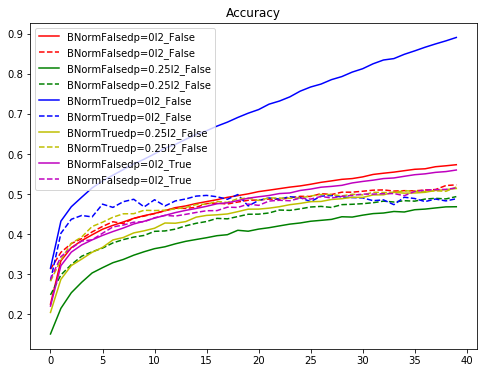

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'#eeefff','#00efff']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()